## [obsolete] Grab ALOS-2 mis-registration time-series from `stripmapStack/refineTiming` step

In [1]:
%matplotlib inline
import os
import glob
import datetime as dt
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt, ticker

from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, writefile, plot as pp
from tools.simulation import iono
from tools import iono_tec
plt.rcParams.update({'font.size': 12})

proj_dir = os.path.expanduser('~/data/geolocation/KyushuAlos2DT23')
work_dir = proj_dir
os.chdir(work_dir)
print('Go to directory:', work_dir)

# dates for pioneer checking with Xiaoqing
dates1 = [
    '20150209', '20150223', '20150810', '20151130',
    '20160307', '20160418', '20170306', '20171113',
    '20180430', '20180709', '20181015', '20190318',
]
dates2 = [
    '20150209', '20150223', '20150810', '20160307',
    '20160516', '20161017', '20161114', '20170306',
    '20171211', '20180416', '20180514', '20190304',
]

Go to directory: /Users/yunjunz/data/geolocation/KyushuAlos2DT23


## Prepare SAR (bulk) offset time-series: stripmapStack -> HDF5/MintPy

azimuth single-look pixel size [m]: 2.35
range   single-look pixel size [m]: 1.43
delete exsited file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesAz.h5
create HDF5 file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesAz.h5 with w mode
create dataset /timeseries of float32    in size of (49, 325, 290)       with compression=None
create dataset /bperp      of float32    in size of (49,)      with compression=None
create dataset /date       of |S8        in size of (49,)      with compression=None
finished writing to /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesAz.h5
delete exsited file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesRg.h5
create HDF5 file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/timeseriesRg.h5 with w mode
create dataset /timeseries of float32    in size of (49, 325, 290)       with compression=None
create dataset /bperp      of float32    in si

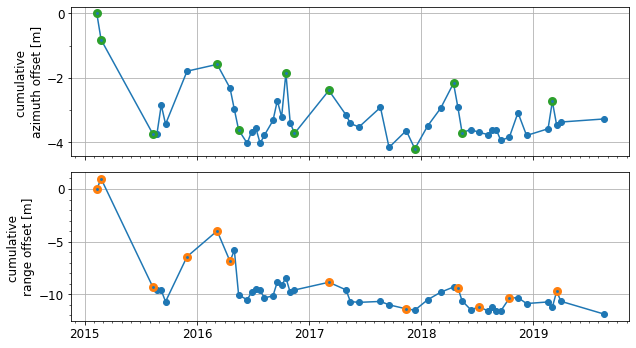

In [32]:
##### get date_list
date_dirs = sorted(glob.glob(os.path.join(proj_dir, 'refineSlaveTiming/dates/*')))
date_list = [os.path.basename(i) for i in date_dirs]
num_date = len(date_list)

##### read az/rg offset time-series
import shelve
import isce
import isceobj
az_off = np.zeros(num_date, dtype=np.float32)
rg_off = np.zeros(num_date, dtype=np.float32)
for i, date_str in enumerate(date_list):
    fname = os.path.join(proj_dir, 'refineSlaveTiming/dates', date_str, 'misreg')
    with shelve.open(fname, flag='r') as f:
        azpoly = f['azpoly']
        rgpoly = f['rgpoly']
    az_off[i] = azpoly.getCoeffs()[0][0]
    rg_off[i] = rgpoly.getCoeffs()[0][0]

# pixel -> meter
ref_ts_file = ref_ts_file = os.path.join(proj_dir, 'mintpy/timeseries.h5')
atr = readfile.read_attribute(ref_ts_file)
az_pixel_size = float(atr['AZIMUTH_PIXEL_SIZE']) / int(atr['ALOOKS'])
rg_pixel_size = float(atr['RANGE_PIXEL_SIZE']) / int(atr['RLOOKS'])
print('azimuth single-look pixel size [m]: {:.2f}'.format(az_pixel_size))
print('range   single-look pixel size [m]: {:.2f}'.format(rg_pixel_size))
az_off *= az_pixel_size
rg_off *= rg_pixel_size

##### write to HDF5/MintPy time-series file
# metadata - remove unrelevant items
for key in list(atr.keys()):
    if key.startswith(('isce.', 'mintpy.', 'REF_')):
        atr.pop(key)
atr['DATA_TYPE'] = 'float32'
atr['REF_DATE'] = date_list[0]
atr['FILE_TYPE'] = 'timeseries'

# dataset
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
az_off_grid = np.tile(az_off.reshape(-1,1,1), (1, length, width))
rg_off_grid = np.tile(rg_off.reshape(-1,1,1), (1, length, width))

# write
az_outfile = os.path.join(proj_dir, 'mintpy_offset/timeseriesAz.h5')
rg_outfile = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg.h5')
writefile.write(az_off_grid, out_file=az_outfile, metadata=atr, ref_file=ref_ts_file)
writefile.write(rg_off_grid, out_file=rg_outfile, metadata=atr, ref_file=ref_ts_file)

# write maskResInv.h5
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
mask_file = os.path.join(proj_dir, 'mintpy_offset/maskResInv.h5')
mask, atr = readfile.read(geom_file, datasetName='waterMask')
atr['FILE_TYPE'] = 'mask'
atr['UNIT'] = '1'
writefile.write(mask, out_file=mask_file, metadata=atr)

##### plot
times = ptime.date_list2vector(date_list)[0]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[9, 5], sharex=True)
axs[0].plot(times, az_off, 'o-')
axs[1].plot(times, rg_off, 'o-')
# dates of interest for pioneer checking
flag1 = np.array([i in dates1 for i in date_list])
axs[1].plot(np.array(times)[flag1], rg_off[flag1], 'o', lw=0, color='C1', mfc='none', mew=3)
flag2 = np.array([i in dates2 for i in date_list])
axs[0].plot(np.array(times)[flag2], az_off[flag2], 'o', lw=0, color='C2', mfc='none', mew=3)


# axis format
for ax, ystep, label in zip(axs, [2,5], ['azimuth offset', 'range offset']):
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ystep))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_ylabel('cumulative \n{} [m]'.format(label))
    #ax.annotate(label, xy=(0.5, 0.85), xycoords='axes fraction', color='k', ha='left')
    ax.grid('on')
pp.auto_adjust_xaxis_date(axs[1], times, every_year=1, buffer_year=None)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_SAR.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Prepare GIM TEC

In [10]:
gim_tec_dir = os.path.expanduser('~/data/aux/GIM_TEC')
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
ts_file   = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg.h5')
tec_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/gimTEC.h5')

# datetime info
atr = readfile.read_attribute(ts_file)
date_list = timeseries(ts_file).get_date_list()
utc_sec = dt.timedelta(seconds=float(atr['CENTER_LINE_UTC']))
dt_objs = [dt.datetime.strptime(i, '%Y%m%d') + utc_sec for i in date_list]

# location
(iono_inc_angle,
 iono_lat,
 iono_lon,
 iono_height) = iono.prep_geometry_iono_shell_along_los(geom_file, print_msg=True)

# zenith TEC
gim_tec = iono.get_gim_tec_list(gim_tec_dir, dt_objs, iono_lat, iono_lon)

## write to HDF5/MintPy format
iono_tec.vtec2iono_ramp_timeseries(date_list, gim_tec.tolist(), geom_file=geom_file, iono_file=tec_file)

incidence angle on the ground     min/max: 34.2/38.1 deg
incidence angle on the ionosphere min/max: 31.6/35.2 deg
center lat/lon  on the ground    : 32.0677/130.7736 deg
center lat/lon  on the ionosphere: 29.3923/130.2832 deg
incidence angle on the ground     min/max: 34.2/38.1 deg
incidence angle on the ionosphere min/max: 31.6/35.2 deg
center lat/lon  on the ground    : 32.0677/130.7736 deg
center lat/lon  on the ionosphere: 29.3923/130.2832 deg
calculating ionospheric phase ramp time-series from TEC ...
[==================================================] 20190819    0s /     0s 
delete exsited file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/inputs/gimTEC.h5
create HDF5 file: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/inputs/gimTEC.h5 with w mode
create dataset /date       of |S8        in size of (49,)                with compression=None
create dataset /vtec       of float32    in size of (49,)                with compression=None
create data

'/Users/yunjunz/data/geolocation/KyushuAlos2DT23/mintpy_offset/inputs/gimTEC.h5'

In [16]:
flag = ~np.isnan(gim_tec)
print('number of dates: {}'.format(num_date))
print('number of dates with GIM TEC: {}'.format(np.sum(flag)))
print('dates with GIM TEC:\n{}'.format(np.array(date_list)[flag]))

number of dates: 49
number of dates with GIM TEC: 12
dates with GIM TEC:
['20150209' '20150223' '20150810' '20151130' '20160307' '20160418'
 '20170306' '20171113' '20180430' '20180709' '20181015' '20190318']


In [14]:
gim_tec_dates

[datetime.datetime(2015, 2, 9, 0, 0),
 datetime.datetime(2015, 2, 23, 0, 0),
 datetime.datetime(2015, 8, 10, 0, 0),
 datetime.datetime(2015, 11, 30, 0, 0),
 datetime.datetime(2016, 3, 7, 0, 0),
 datetime.datetime(2016, 4, 18, 0, 0),
 datetime.datetime(2017, 3, 6, 0, 0),
 datetime.datetime(2017, 11, 13, 0, 0),
 datetime.datetime(2018, 4, 30, 0, 0),
 datetime.datetime(2018, 7, 9, 0, 0),
 datetime.datetime(2018, 10, 15, 0, 0),
 datetime.datetime(2019, 3, 18, 0, 0)]

## Prepare IGS TEC / SET / ERA5

```bash
iono_tec.py timeseriesRg.h5 -g inputs/geometryRadar.h5
solid_earth_tides.py timeseriesRg.h5 -g inputs/geometryRadar.h5 
tropo_pyaps3.py -f timeseriesRg_SET.h5 -g inputs/geometryRadar.h5 
```